# Recurrent Neural Net Part 3

This notebook is based on a tutorial: "Multivariate Time Series using RNN with Keras" from [here](https://medium.com/datadriveninvestor/multivariate-time-series-using-rnn-with-keras-7f78f4488679)



## Meeting Agenda


1. Introduction
2. Project Updates
3. RNN Code Walkthrough
4. AI Model Deployment





## RNN Example Code

In [0]:
import numpy as np
import pandas as pd
import math
from keras import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
total_training = []
total_validation = []



First, we download a csv export of the Google stock from [here](https://www.nasdaq.com/symbol/goog/historical).

For convenience, this is saved in the presentations repository and can be access by URL.

**Note:** 

We need to use the thousands=',' parameter in order to ignore the commas in the numbers when converting to floats.

We'll use the head() method to get a look at what the dataframe looks like.

In [3]:
fileURL = "https://github.com/HSV-AI/presentations/raw/master/2019/190619/HistoricalQuotes.csv"
stock_data = pd.read_csv(fileURL, thousands=',')
stock_data.head(5)

,date,close,volume,open,high,low
0,16:00,1103.60,1386584.0,1107.82,1116.39,1098.9900
1,2019/06/18,1103.60,1386684.0,1109.69,1116.39,1098.9900
2,2019/06/17,1092.50,941602.0,1086.28,1099.18,1086.2800
3,2019/06/14,1085.35,1111643.0,1086.42,1092.69,1080.1721
4,2019/06/13,1088.77,1058000.0,1083.64,1094.17,1080.1500


In [4]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 6 columns):
date      1260 non-null object
close     1260 non-null float64
volume    1260 non-null float64
open      1260 non-null float64
high      1260 non-null float64
low       1260 non-null float64
dtypes: float64(5), object(1)
memory usage: 59.1+ KB


The example showed how to use 2 values as input - the volume and an average of the high/low price. I've changed this to just use the 5 values individually and let the network figure out how they might be related when predicting an output.

In [5]:
input_feature= stock_data.iloc[:,1:].values
input_data = input_feature
input_feature.shape

output_feature = stock_data.iloc[:,[1,3]].values

print(input_feature.shape)
print(output_feature.shape)
stock_data.iloc[:,1:].head(5)

(1260, 5)
(1260, 2)


,close,volume,open,high,low
0,1103.60,1386584.0,1107.82,1116.39,1098.9900
1,1103.60,1386684.0,1109.69,1116.39,1098.9900
2,1092.50,941602.0,1086.28,1099.18,1086.2800
3,1085.35,1111643.0,1086.42,1092.69,1080.1721
4,1088.77,1058000.0,1083.64,1094.17,1080.1500


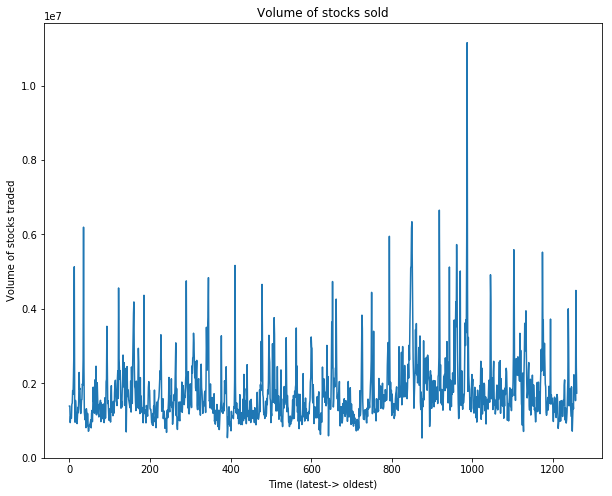

In [6]:
plt.figure(figsize=(10,8))
plt.plot(input_feature[:,1])
plt.title("Volume of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Volume of stocks traded")
plt.show()

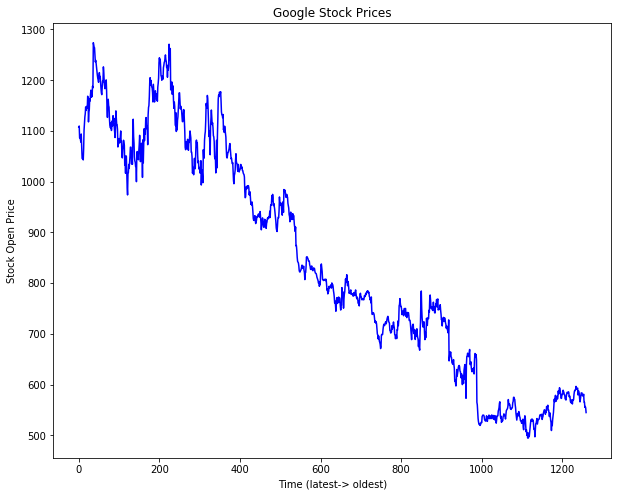

In [7]:
plt.figure(figsize=(10,8))
plt.plot(input_feature[:,2], color='blue')
plt.title("Google Stock Prices")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Open Price")
plt.show()

In [0]:
input_scaler = MinMaxScaler(feature_range=(0,1))
input_data[:,:] = input_scaler.fit_transform(input_feature[:,:])

output_scaler = MinMaxScaler(feature_range=(0,1))
# output_feature = output_feature.reshape(-1, 1)
output_data = output_scaler.fit_transform(output_feature[:,:])

In [0]:
lookback= 50

X=[]
y=[]
for i in range(len(stock_data)-lookback-1):
    t=[]
    for j in range(0,lookback):
        t.append(input_data[[(i+j)], :])

    X.append(t)
    y.append(output_data[i+ lookback])

In [10]:
X, y= np.array(X), np.array(y)
X = X.reshape(X.shape[0],lookback, 5)

print(X.shape)
print(y.shape)

(1209, 50, 5)
(1209, 2)


In [12]:
model = Sequential()
model.add(LSTM(units=30, return_sequences= True, input_shape=(X.shape[1],5)))
model.add(LSTM(units=30, return_sequences=True))
model.add(LSTM(units=30))
model.add(Dense(units=2))
model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 50, 30)            4320      
_________________________________________________________________
lstm_5 (LSTM)                (None, 50, 30)            7320      
_________________________________________________________________
lstm_6 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 62        
Total params: 19,022
Trainable params: 19,022
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='adam', loss='mean_squared_error')

W0626 22:12:08.926577 140698563360640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



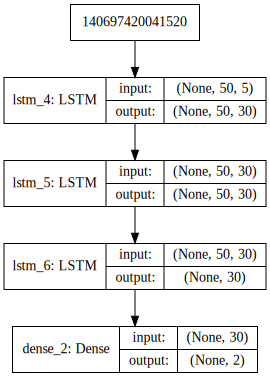

In [14]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [0]:
def plot_loss(history):

  length = len(history.history['loss'])
  rng = range(length)

  training_fit = np.polyfit(rng, history.history['loss'], 1)
  training_trend = np.poly1d(training_fit)

  val_fit = np.polyfit(rng, history.history['val_loss'], 1)
  val_trend = np.poly1d(val_fit)

  plt.figure(figsize=(10,8))
  plt.plot(history.history['loss'], color='green')
  plt.plot(training_trend(rng), color='green', linestyle='--')
  plt.plot(history.history['val_loss'], color='orange')
  plt.plot(val_trend(rng), color='orange', linestyle='--')

  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Training', 'Training Trend', 'Validation', 'Validation Trend'], loc='lower left')
  plt.show()


Originally, we had this line:

history = model.fit(X, y, validation_split=0.30, epochs=50, batch_size=32, verbose=1)

The problem is that the validation split always takes the validation off of the back of the data, instead of randomly selecting 30% for validation.

To change this up, we will use the train_test_split from sklearn to give us a random 30% validation set. Then we will train for 50 epochs and graph the training loss and validation loss to see how we're doing.

We will repeat this for a few times to see how low the error drops.


W0626 22:12:19.481230 140698563360640 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0626 22:12:21.329057 140698563360640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0626 22:12:21.484905 140698563360640 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 5s 6ms/step - loss: 0.0493 - val_loss: 0.0074
Epoch 2/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 3/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0019 - val_loss: 0.0015
Epoch 4/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0017 - val_loss: 0.0015
Epoch 5/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0017 - val_loss: 0.0014
Epoch 6/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0016 - val_loss: 0.0013
Epoch 7/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 8/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0017 - val_loss: 0.0018
Epoch 9/50
846/846 [==============================] - 2s 3ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 10/50
846/846 [==============================] -

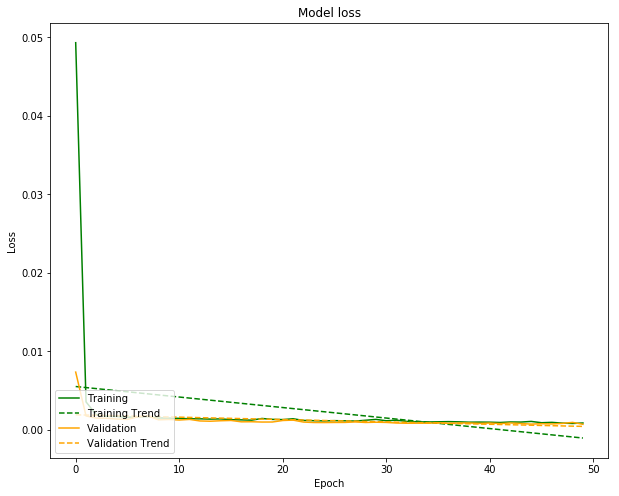

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 2s 3ms/step - loss: 7.8567e-04 - val_loss: 8.3607e-04
Epoch 2/50
846/846 [==============================] - 2s 3ms/step - loss: 8.8357e-04 - val_loss: 8.1796e-04
Epoch 3/50
846/846 [==============================] - 2s 3ms/step - loss: 8.3822e-04 - val_loss: 7.4931e-04
Epoch 4/50
846/846 [==============================] - 2s 3ms/step - loss: 8.2381e-04 - val_loss: 8.2596e-04
Epoch 5/50
846/846 [==============================] - 2s 3ms/step - loss: 7.6646e-04 - val_loss: 7.2589e-04
Epoch 6/50
846/846 [==============================] - 2s 3ms/step - loss: 8.4898e-04 - val_loss: 8.1355e-04
Epoch 7/50
846/846 [==============================] - 2s 3ms/step - loss: 8.9905e-04 - val_loss: 7.0409e-04
Epoch 8/50
846/846 [==============================] - 2s 3ms/step - loss: 8.4297e-04 - val_loss: 7.0732e-04
Epoch 9/50
846/846 [==============================] - 2s 3ms/step - loss: 7.1665e-04 - val

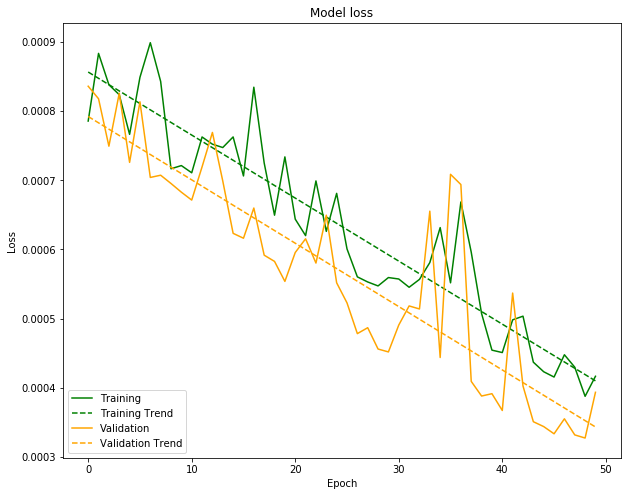

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 2s 3ms/step - loss: 3.6714e-04 - val_loss: 4.1345e-04
Epoch 2/50
846/846 [==============================] - 2s 3ms/step - loss: 3.5691e-04 - val_loss: 3.5829e-04
Epoch 3/50
846/846 [==============================] - 2s 3ms/step - loss: 3.4347e-04 - val_loss: 3.9090e-04
Epoch 4/50
846/846 [==============================] - 2s 3ms/step - loss: 3.6989e-04 - val_loss: 3.7556e-04
Epoch 5/50
846/846 [==============================] - 2s 3ms/step - loss: 3.6009e-04 - val_loss: 3.4568e-04
Epoch 6/50
846/846 [==============================] - 2s 3ms/step - loss: 3.6599e-04 - val_loss: 3.3915e-04
Epoch 7/50
846/846 [==============================] - 2s 3ms/step - loss: 3.4199e-04 - val_loss: 3.4132e-04
Epoch 8/50
846/846 [==============================] - 2s 3ms/step - loss: 3.1425e-04 - val_loss: 3.2638e-04
Epoch 9/50
846/846 [==============================] - 2s 3ms/step - loss: 3.4761e-04 - val

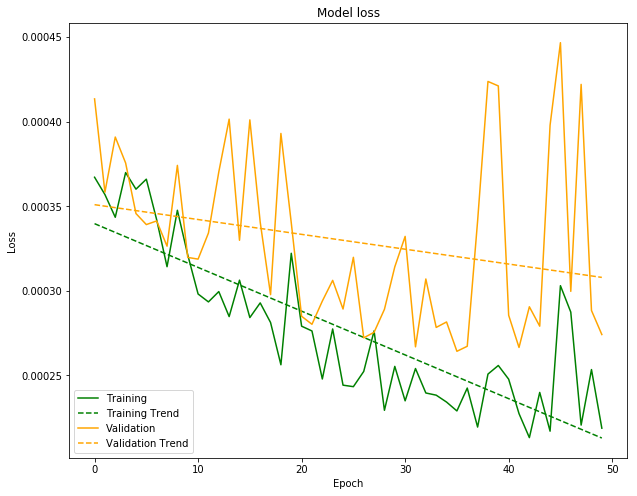

Train on 846 samples, validate on 363 samples
Epoch 1/50
846/846 [==============================] - 2s 3ms/step - loss: 2.3371e-04 - val_loss: 2.1271e-04
Epoch 2/50
846/846 [==============================] - 2s 3ms/step - loss: 2.4240e-04 - val_loss: 2.1845e-04
Epoch 3/50
846/846 [==============================] - 2s 3ms/step - loss: 2.4028e-04 - val_loss: 2.1864e-04
Epoch 4/50
846/846 [==============================] - 2s 3ms/step - loss: 2.6314e-04 - val_loss: 2.1681e-04
Epoch 5/50
846/846 [==============================] - 2s 3ms/step - loss: 2.4452e-04 - val_loss: 2.4099e-04
Epoch 6/50
846/846 [==============================] - 2s 3ms/step - loss: 2.3376e-04 - val_loss: 2.3247e-04
Epoch 7/50
846/846 [==============================] - 2s 3ms/step - loss: 2.5632e-04 - val_loss: 2.1544e-04
Epoch 8/50
846/846 [==============================] - 2s 3ms/step - loss: 2.6193e-04 - val_loss: 2.0350e-04
Epoch 9/50
846/846 [==============================] - 2s 3ms/step - loss: 3.4183e-04 - val

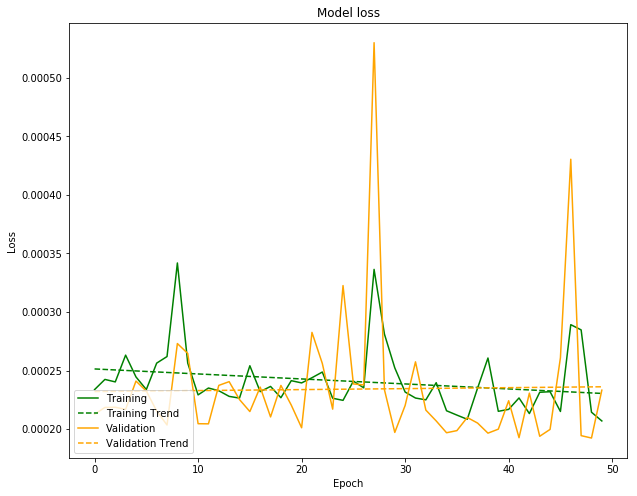

In [16]:
for i in range(4):
  XTraining, XValidation, YTraining, YValidation = train_test_split(X,y,test_size=0.3) # before model building
  history = model.fit(XTraining, YTraining, batch_size=32, epochs=50, validation_data=(XValidation,YValidation))
  total_training.extend(history.history['loss'])
  total_validation.extend(history.history['val_loss'])
  
  # Plot training & validation loss values
  plot_loss(history)


Now we'll take a look at the final results of the training/validation error. We throw out the first 10 epochs of training, as they vary wildly before any real training begins.

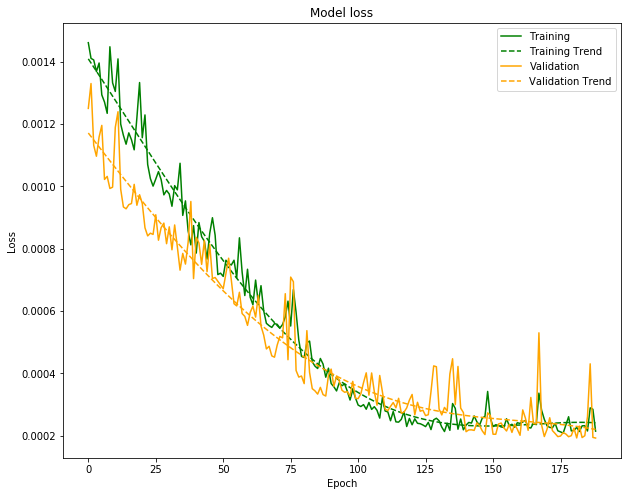

In [17]:
length = len(total_training[10:-1])
rng = range(length)

training_fit = np.polyfit(rng, total_training[10:-1], 4)
training_trend = np.poly1d(training_fit)

val_fit = np.polyfit(rng, total_validation[10:-1], 4)
val_trend = np.poly1d(val_fit)

plt.figure(figsize=(10,8))
plt.plot(total_training[10:-1], color='green')
plt.plot(training_trend(rng), color='green', linestyle='--')
plt.plot(total_validation[10:-1], color='orange')
plt.plot(val_trend(rng), color='orange', linestyle='--')

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Training Trend', 'Validation', 'Validation Trend'], loc='upper right')
plt.show()


In [20]:
predicted_value = model.predict(X)
unscaled_output = output_scaler.inverse_transform(predicted_value)
print(predicted_value.shape)

temp = np.array(stock_data.open[lookback:-1]).reshape(-1,1)


(1209, 2)


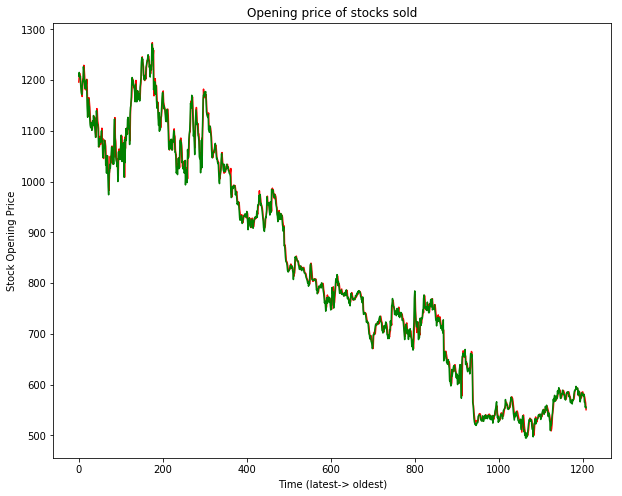

In [21]:

plt.figure(figsize=(10,8))
plt.plot(unscaled_output[:,0], color= 'red')
plt.plot(temp, color='green')
plt.title("Opening price of stocks sold")
plt.xlabel("Time (latest-> oldest)")
plt.ylabel("Stock Opening Price")
plt.show()